# Sampling from the Learned Distrubtion

In this notebook, we will show how to sample from the learned distribution of solutions with the trained neural networks. You can run this note book directly in [colab](https://colab.research.google.com/github/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/sample.ipynb).

First, we need to prepare the dataset for sampling. If you are not familiar with the data structure and the `DataFiles` class we used to organize the dataset, please refer to `generate_dataset.ipynb` and `process_dataset.ipynb`

In [ ]:
# run this cell to install the required packages and clone the repository if you are using colab
%pip install einops bayesian_torch
!git clone https://github.com/tum-pbs/Diffusion-based-Flow-Prediction.git
%cd Diffusion-based-Flow-Prediction/

In [ ]:
import zipfile
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files): 
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close() 
        
df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_all=DataFiles(df_train.case_list+df_test.case_list)

The test dataset consists of 6 simulations with raf30 airfoil. The angle of attack is 20 $\degree$ and the $Re$ ranges from $0.5 \times 10^6$ to $10.5 \times 10^6$. Let's first have a look at how the ground truth mean field and the standard deviation of these simulation cases look like:

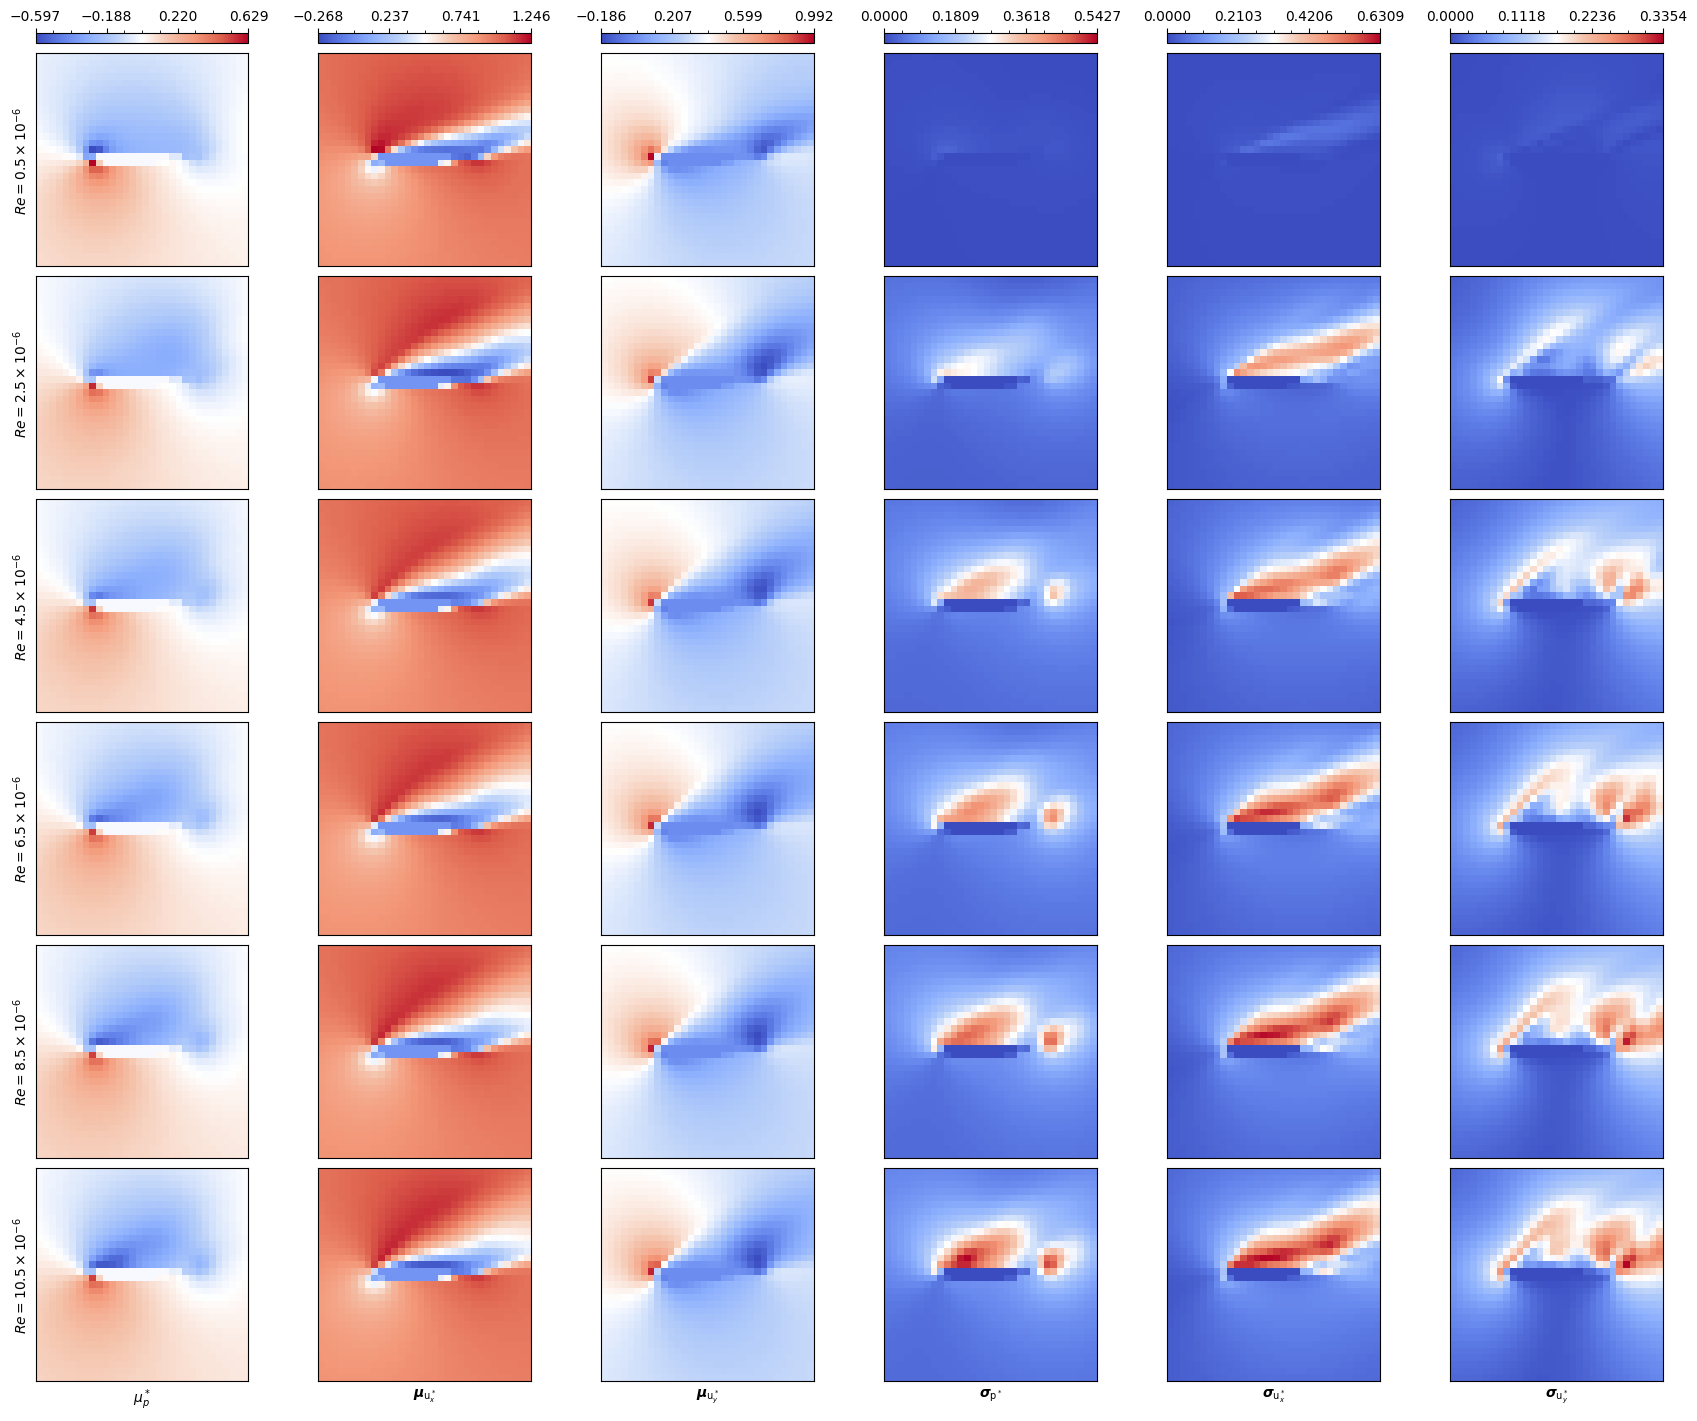

In [4]:
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))   
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

from airfoil_diffusion.plotter import *
CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]
show_each_channel(np.concatenate([mean_field_test_gd,std_field_test_gd],axis=1),
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=[r"$Re={}\times$".format(0.5 +2*i)+"$10^{-6}$" for i in range(6)],transpose=True,inverse_y=True)

We can use different models to predict these mean and standard deviation distributions. 

For the diffusion model, the neural network predicts the noise during the diffusion procedure. Thus, we need an additional `diffuser` to sample the final solutions. Since each sample of the diffusion model represents a sample from the original simulation distribution, we need to do multiple samples to get the average and the standard deviation distribution: 

In [3]:
def sample_diffusion(network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    diffuser=Cos2ParamsDiffuser(200,device=device)
    while True:
        if N_all<=0:
            break
        if N_all<batch_size:
            batch_size_now=N_all
            N_all=0
        else:
            N_all-=batch_size
            batch_size_now=batch_size
        prediction_batch=normalized2dimless(diffuser.sample_from_noise(network,input_field.to(device).repeat(batch_size_now,1,1,1),show_progress=False))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

The neural network of BNN directly predicts the final samples. Therefore, we don't need additional calculations besides the neural network inference. Similar to the diffusion model, BNN also needs multiple sampling to get the mean and standard deviation distribution:

In [4]:
def sample_BNN(network,input_field,num_BNN_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_BNN_sample
    while True:
        if N_all<=0:
            break
        if N_all<batch_size:
            batch_size_now=N_all
            N_all=0
        else:
            N_all-=batch_size
            batch_size_now=batch_size
        prediction_batch=normalized2dimless(
            network(input_field.to(device).repeat(batch_size_now,1,1,1),torch.tensor([200],device=device),None)
            )
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

For the heteroscedastic model, the neural network directly predicts the mean and standard deviation distribution, which means that we don't need to sample from the distribution:

In [5]:
def sample_heteroscedastic(network,input_field):
    network.eval();network.to(device)
    prediction=network(input_field.to(device),torch.tensor([200],device=device),None)
    mean=normalized2dimless(prediction[0,0:3,:,:]).detach().cpu().numpy()
    std=torch.sqrt(torch.exp(prediction[0,3:,:,:]))
    std=normalized2dimless(std).detach().cpu().numpy()
    return mean,std,None

Now, let's see some predictions of these models！ 

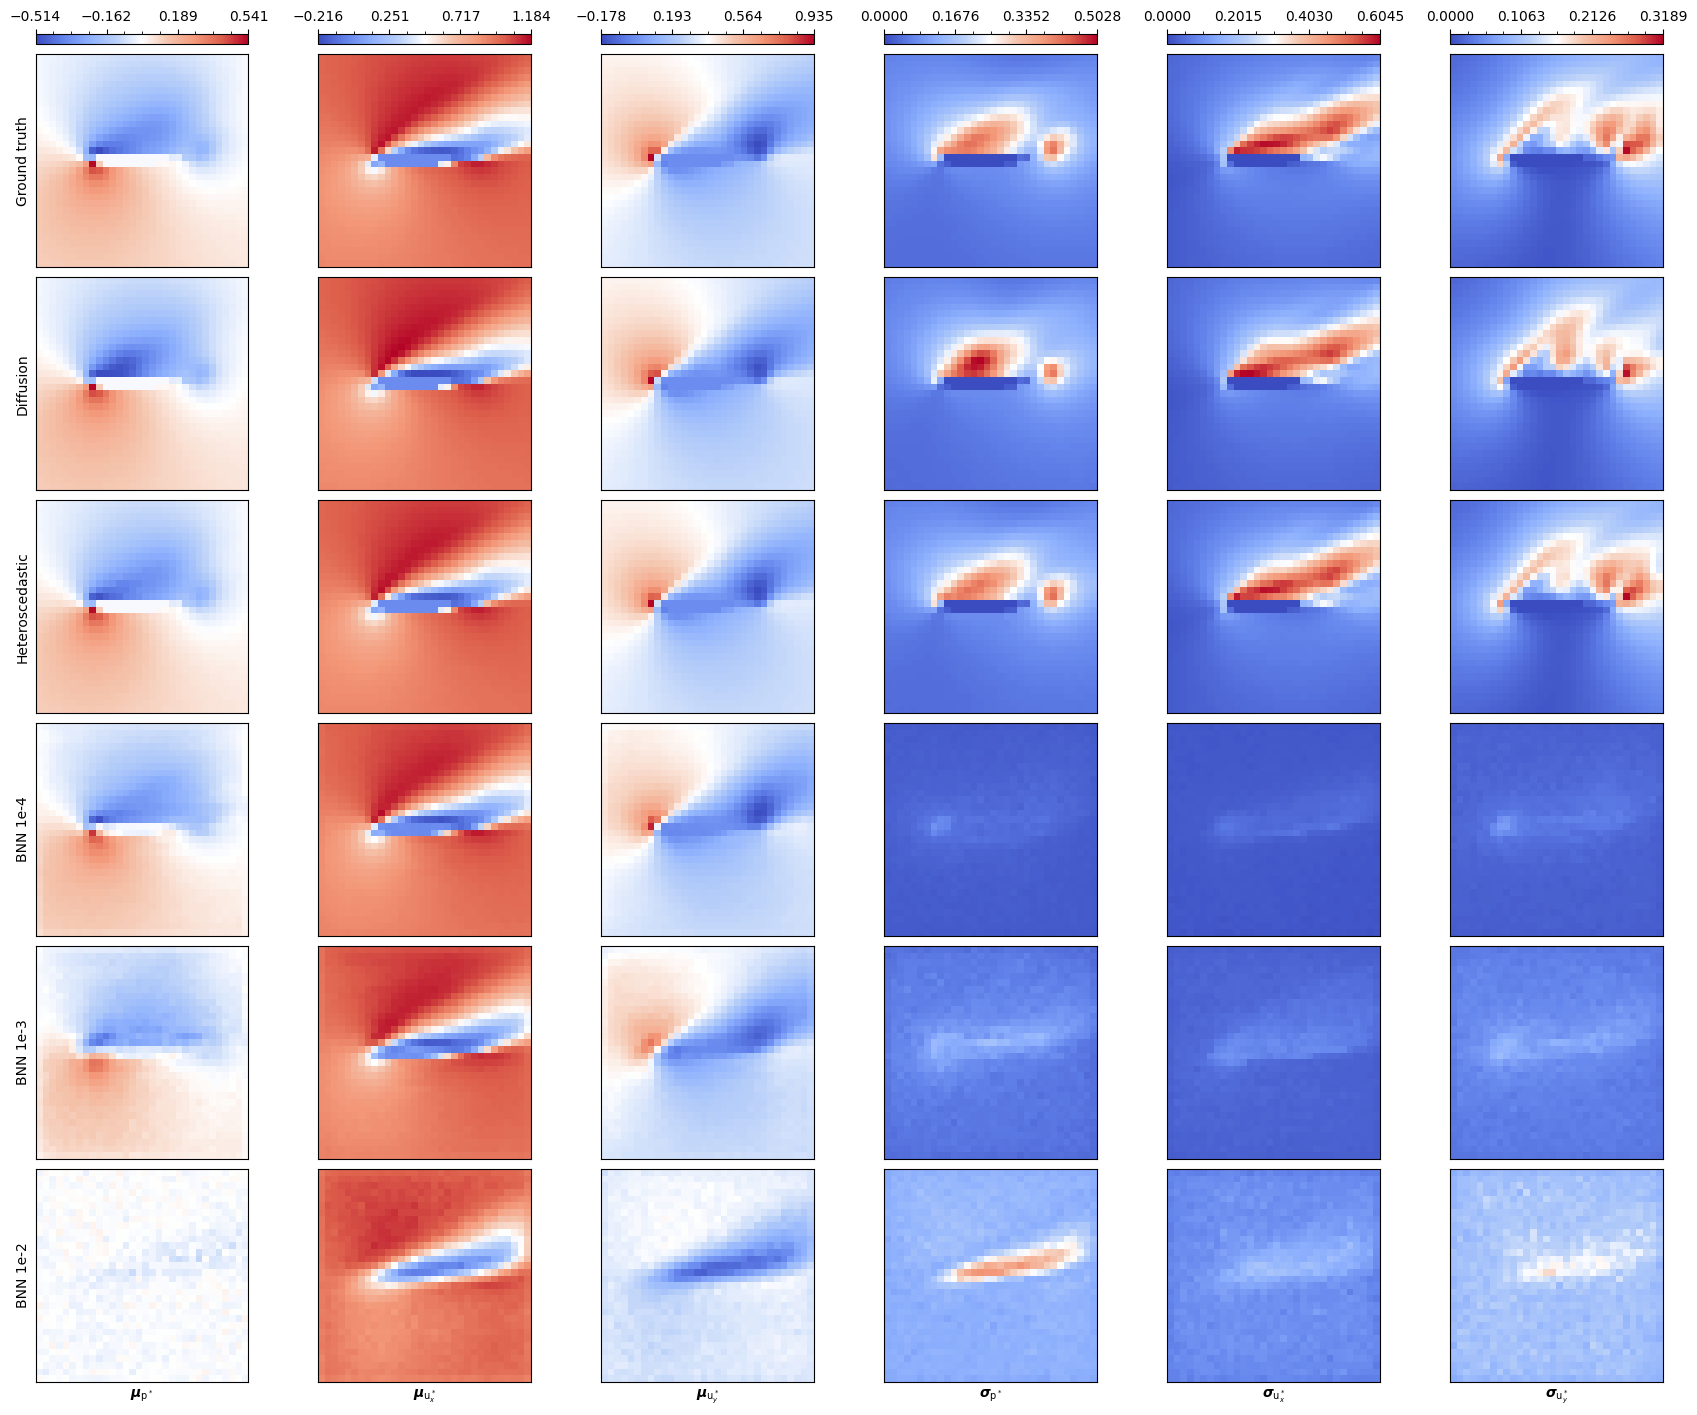

In [6]:
index=3

input_field=inputs_test[index].unsqueeze(0)

dif_network=AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml")
dif_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/diffusion/weights_0.pt"))
mean,std,samples_diffusion=sample_diffusion(dif_network,input_field,num_diffusion_sample=100)
result_diffusion=np.concatenate([mean,std],axis=0)

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn
const_bnn_prior_parameters = read_configs("./pre_trained/single_parameter/32/BNN/bnn_configs.yaml")
BNN_network=AifNet("./pre_trained/single_parameter/32/BNN/network_configs.yaml")
dnn_to_bnn(BNN_network, const_bnn_prior_parameters)
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-4_weights_0.pt"))
mean,std,samples_BNN_m4=sample_BNN(BNN_network,input_field,num_BNN_sample=100)
result_BNN_m4=np.concatenate([mean,std],axis=0)
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-3_weights_0.pt"))
mean,std,samples_BNN_m3=sample_BNN(BNN_network,input_field,num_BNN_sample=100)
result_BNN_m3=np.concatenate([mean,std],axis=0)
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-2_weights_0.pt"))
mean,std,samples_BNN_m2=sample_BNN(BNN_network,input_field,num_BNN_sample=100)
result_BNN_m2=np.concatenate([mean,std],axis=0)

he_network=AifNet("./pre_trained/single_parameter/32/heteroscedastic/network_configs.yaml")
he_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/heteroscedastic/weights_0.pt"))
mean,std,_=sample_heteroscedastic(he_network,input_field)
result_he=np.concatenate([mean,std],axis=0)

result_ground_truth=np.concatenate([mean_field_test_gd[index],std_field_test_gd[index]],axis=0)
show_each_channel([result_ground_truth,result_diffusion,result_he,result_BNN_m4,result_BNN_m3,result_BNN_m2],
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=["Ground truth","Diffusion","Heteroscedastic","BNN 1e-4","BNN 1e-3","BNN 1e-2"],transpose=True,inverse_y=True)

It looks like that the diffusion model and heteroscedastic model give well estimation on the distributions while BNN show very noisy distribution especially when the KL scaling factor is higher. 

Let's do some more quantitative comparisons. For example, we can measure how the average mean square error changes with Reynolds number:

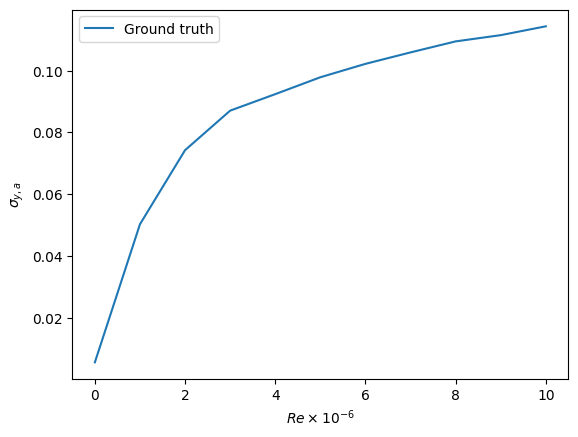

In [7]:
df_all.sort()
std_groundtruth=[]
for case in df_all.get_simulation_cases():
    datas=[]
    selected_cases=df_all.select_simulation_cases([case])
    for case in selected_cases:
        datas.append(
            read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)[3:] # scale factor is 0.25 to geet 32 $\times$ 32 data
            )
    std_groundtruth.append(np.stack(datas,axis=0).std(axis=0).mean())   
plt.plot(std_groundtruth,label="Ground truth")
plt.legend()
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()

By performing the sampling on the whole test dataset, we can compare our predictions with the ground truth:

In [8]:
def do_test(sample_func):
    mean_predictions=[]
    std_predictions=[]
    std_a_predictions=[]
    for input_field in tqdm(inputs_test):
        mean_fields,std_fields,_=sample_func(input_field.unsqueeze(0))
        mean_predictions.append(mean_fields)
        std_predictions.append(std_fields)
        std_a_predictions.append(np.mean(std_fields))
    return mean_predictions,std_predictions,std_a_predictions 

If you find that running the code below is too time-consuming, try reducing the number of samples (`num_diffusion_sample` and `num_BNN_sample`).

In [9]:
mean_predictions_dif,std_predictions_dif,std_a_predictions_dif=do_test(lambda x:sample_diffusion(dif_network,x,num_diffusion_sample=500))
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-4_weights_0.pt"))
mean_predictions_BNN_m4,std_predictions_BNN_m4,std_a_predictions_BNN_m4=do_test(lambda x:sample_BNN(BNN_network,x,num_BNN_sample=500))
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-3_weights_0.pt"))
mean_predictions_BNN_m3,std_predictions_BNN_m3,std_a_predictions_BNN_m3=do_test(lambda x:sample_BNN(BNN_network,x,num_BNN_sample=500))
BNN_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/BNN/1e-2_weights_0.pt"))
mean_predictions_BNN_m2,std_predictions_BNN_m2,std_a_predictions_BNN_m2=do_test(lambda x:sample_BNN(BNN_network,x,num_BNN_sample=500))
mean_predictions_he,std_predictions_he,std_a_predictions_he=do_test(lambda x:sample_heteroscedastic(he_network,x))

100%|██████████| 6/6 [00:00<00:00, 120.96it/s]


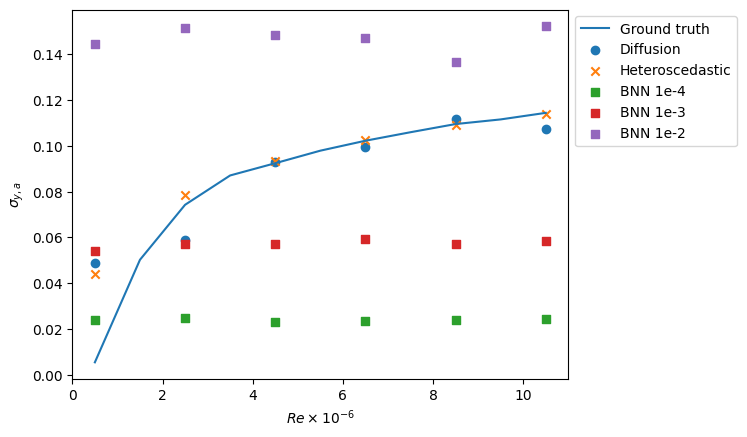

In [10]:
x=[0.5 +2*i for i in range(6)]
plt.plot([0.5 +i for i in range(11)],std_groundtruth,label="Ground truth")
plt.scatter(x,std_a_predictions_dif,label="Diffusion",marker="o")
plt.scatter(x,std_a_predictions_he,label="Heteroscedastic",marker="x")
plt.scatter(x,std_a_predictions_BNN_m4,label="BNN 1e-4",marker="s")
plt.scatter(x,std_a_predictions_BNN_m3,label="BNN 1e-3",marker="s")
plt.scatter(x,std_a_predictions_BNN_m2,label="BNN 1e-2",marker="s")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()

Still, diffusion and heteroscedastic models give satisfying predictions, while the variation of standard deviation predicted by BNN is far from the ground truth. It seems that an "accurate" KL scaling factor exists to shift the BNN's prediction closer to the ground truth, but it is hard to find it.

We can also closely examine samples rather than their statistical features. For example, we can illustrate five samples of pressure filed from our previous predictions:

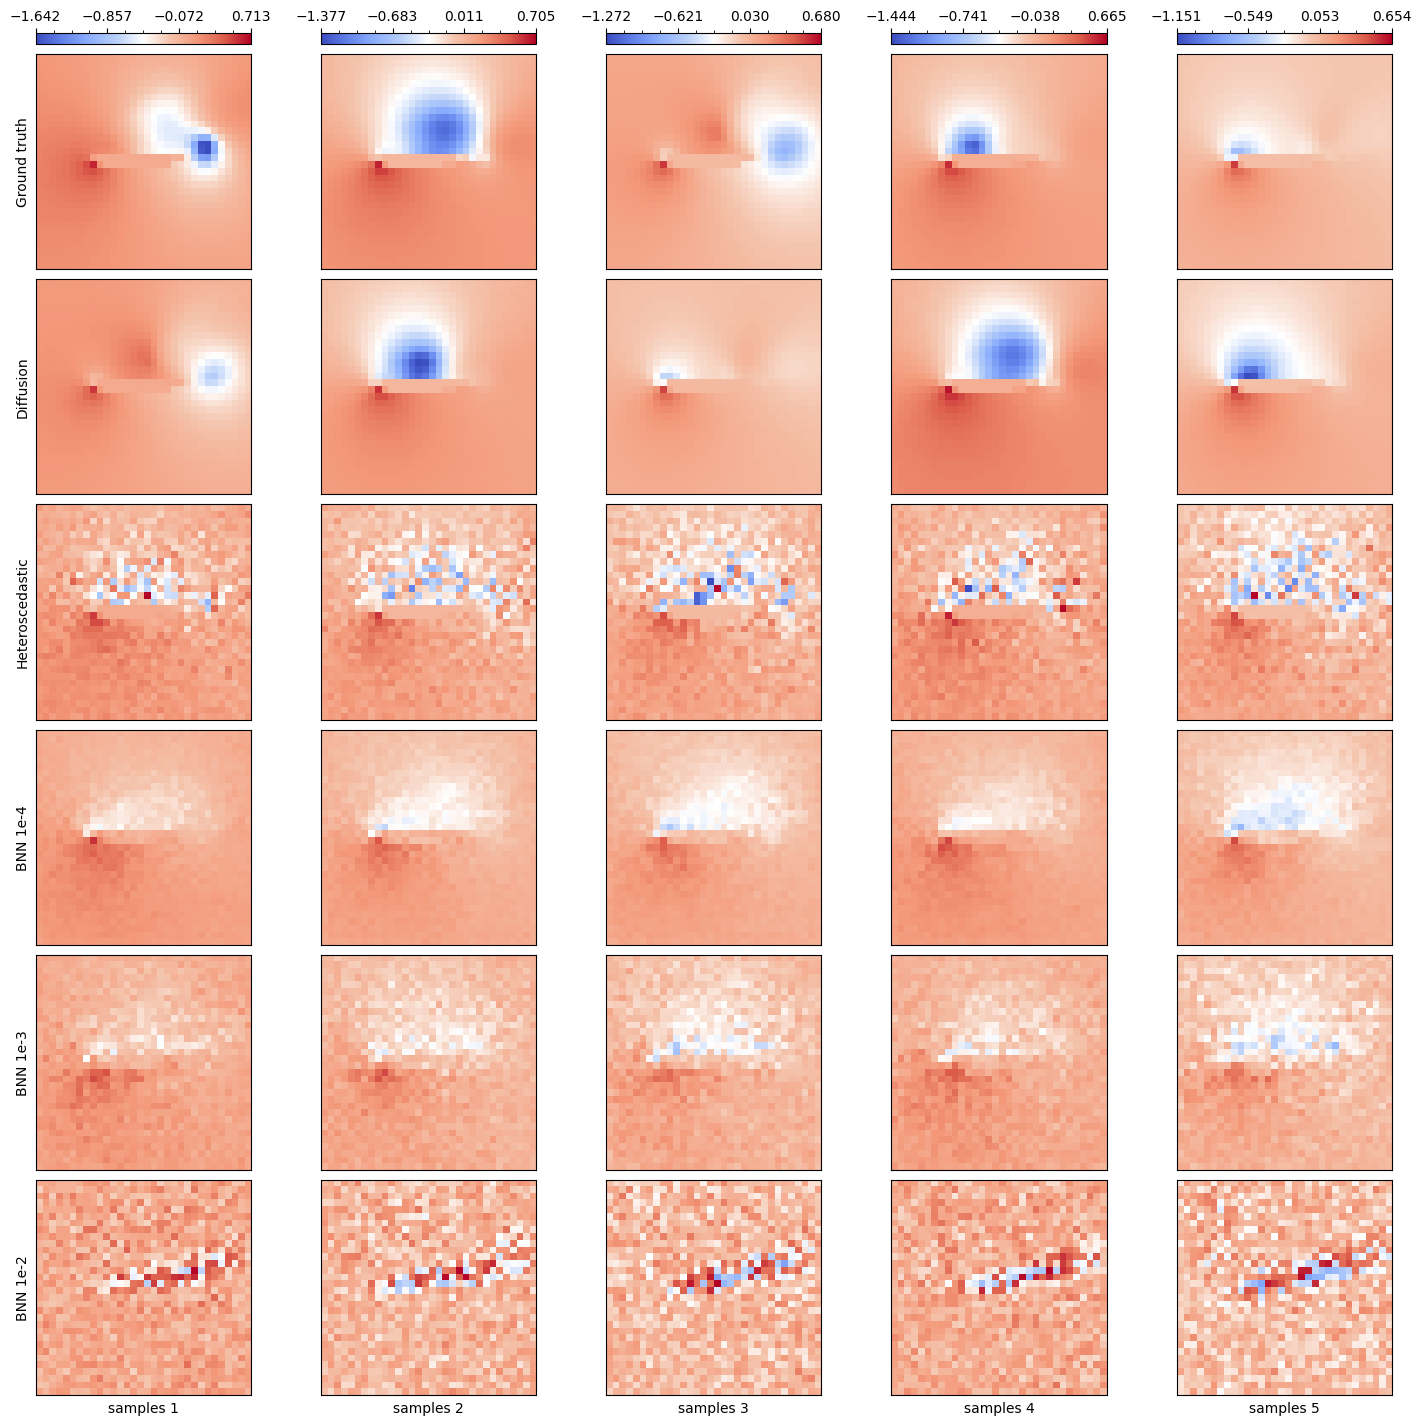

In [11]:
p_samples_gd=samples_gd[index][(0,5,10,15,20),:,:,:][:,0,:,:]
p_samples_diffusion=samples_diffusion[(0,5,10,15,20),:,:,:][:,0,:,:]
mean_he=result_he[0:3]
std_he=result_he[3:]
p_samples_he=np.stack([mean_he[0]+np.random.randn(32,32)*std_he[0] for i in range(5)],axis=0)
p_samples_BNN_m4=samples_BNN_m4[(0,5,10,15,20),:,:,:][:,0,:,:]
p_samples_BNN_m3=samples_BNN_m3[(0,5,10,15,20),:,:,:][:,0,:,:]
p_samples_BNN_m2=samples_BNN_m2[(0,5,10,15,20),:,:,:][:,0,:,:]

show_each_channel(
    [p_samples_gd,p_samples_diffusion,p_samples_he,p_samples_BNN_m4,p_samples_BNN_m3,p_samples_BNN_m2],
    channel_names=["samples {}".format(ifield+1) for ifield in range(5)],
    case_names=["Ground truth","Diffusion","Heteroscedastic","BNN 1e-4","BNN 1e-3","BNN 1e-2"]
    ,transpose=True,inverse_y=True
)

The predictions of BNN are very noisy, which is not surprising. However, opposite to its statics features, the samples of the heteroscedastic model are also very noisy. This is because the heteroscedastic model assumes a Gaussian distribution for each data pixel while neglecting the correlation between different pixels. In fact, only the diffusion model faithfully reproduces the samples of the ground truth. And importantly, the graph above shows that it does so with the right amount of variance across the range of different Reynolds numbers.